Testando Primeiro Algoritmo para converter as mascaras para o yolo
Usando o floodfill, onde basicamente substituimos o fundo preto para cinza para ajudar na criação do dataset YOLO

🔬 Analisando 10 imagens aleatórias com FloodFill...


/tmp/ipython-input-3171975617.py:91: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


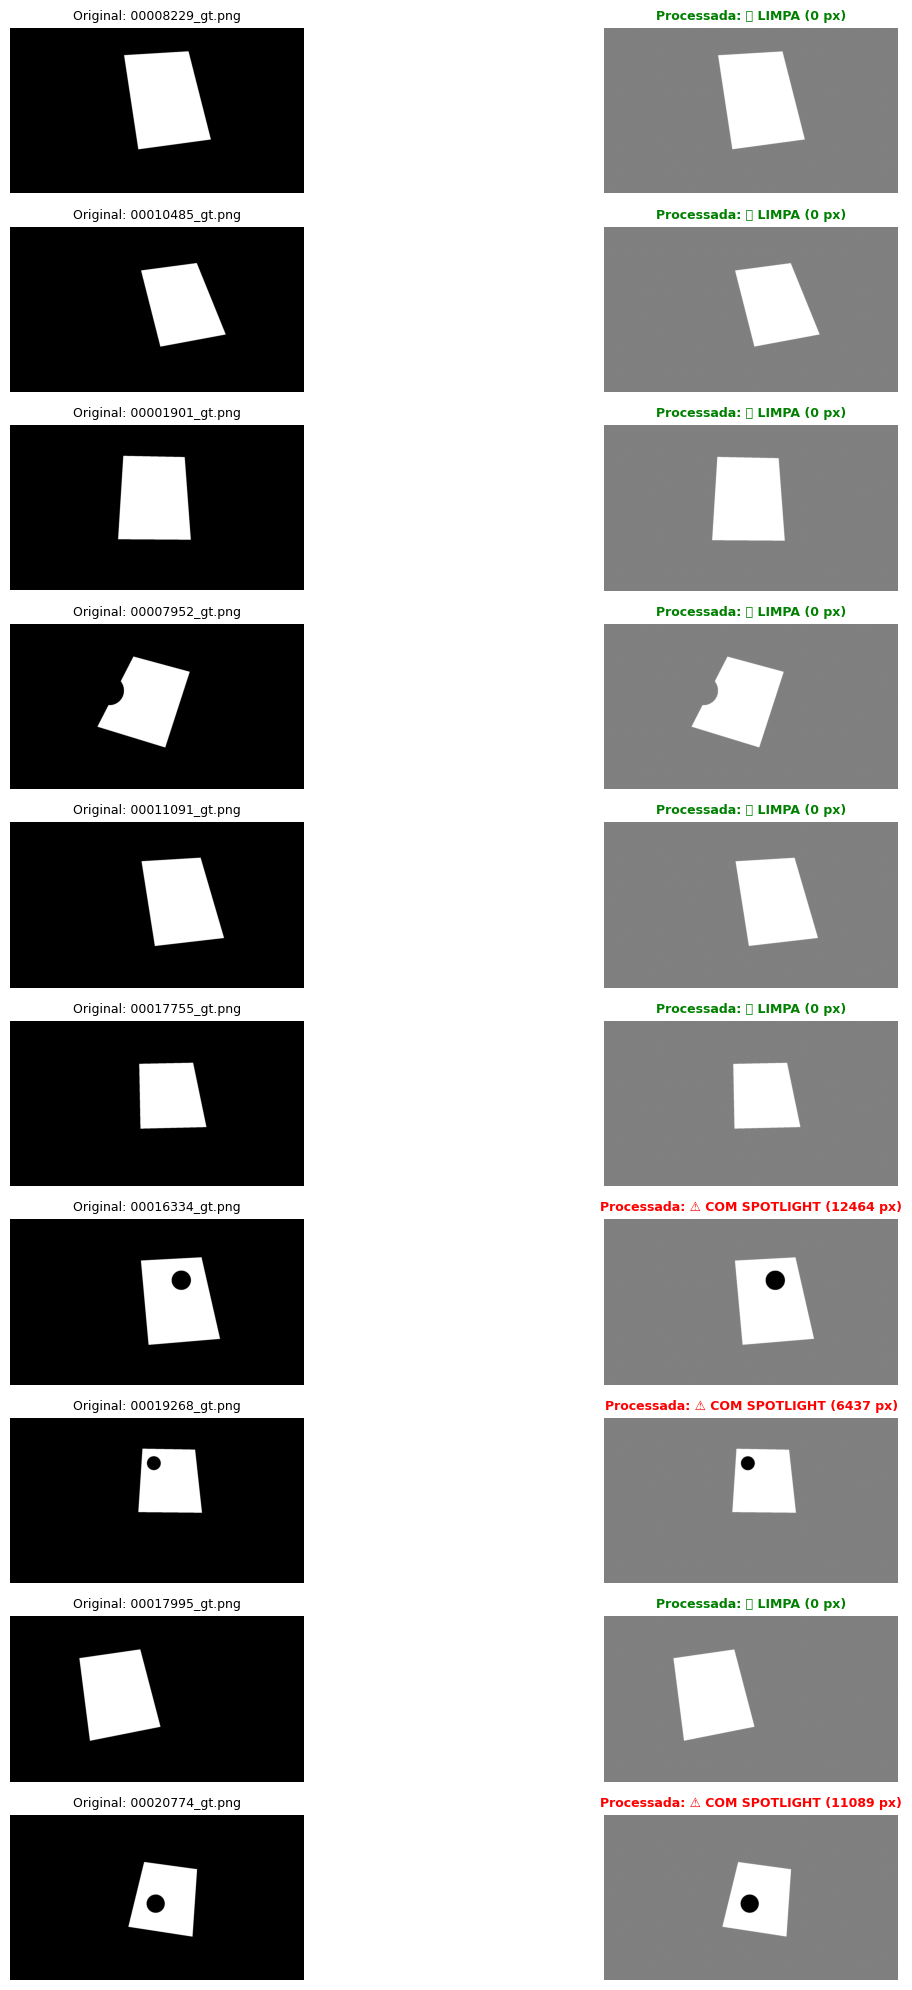

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# ==============================================================================
# VISUALIZADOR DE DEBUG: LÓGICA FLOODFILL
# ==============================================================================

# SEU CAMINHO DO DATASET (Verifique se está correto)
RAW_DATASET_PATH = Path("/content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID Set Dataset")

def debug_floodfill_logic(mask_path):
    """
    Aplica a lógica e retorna a imagem processada para visualização
    """
    # 1. Ler máscara
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None: return None, None, "Erro"

    # 2. Binarizar
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 3. Adicionar borda (para o FloodFill não falhar nas quinas)
    h, w = binary_mask.shape
    mask_with_border = cv2.copyMakeBorder(binary_mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

    # 4. FloodFill (Pintar o fundo preto de cinza 128)
    h_flood, w_flood = mask_with_border.shape
    flood_mask = np.zeros((h_flood + 2, w_flood + 2), np.uint8)

    # Copia para visualização antes de pintar
    debug_img = mask_with_border.copy()

    # Pinta o fundo de cinza (128)
    cv2.floodFill(debug_img, flood_mask, (0,0), 128)

    # 5. Contar Spotlight (pixels que continuaram pretos - 0)
    spotlight_pixels = np.sum(debug_img == 0)
    has_spotlight = spotlight_pixels > 100

    return binary_mask, debug_img, has_spotlight, spotlight_pixels

def show_preview():
    if not RAW_DATASET_PATH.exists():
        print(f"❌ Caminho não encontrado: {RAW_DATASET_PATH}")
        return

    # Pegar amostras
    train_masks = list((RAW_DATASET_PATH / 'train_folder').glob("*_gt.png"))
    val_masks = list((RAW_DATASET_PATH / 'validation_folder').glob("*_gt.png"))

    if not train_masks:
        print("❌ Nenhuma máscara encontrada! Verifique o caminho.")
        return

    # Selecionar 5 de cada (aleatório)
    samples = random.sample(train_masks, 5) + random.sample(val_masks, 5)

    print(f"🔬 Analisando 10 imagens aleatórias com FloodFill...")

    plt.figure(figsize=(15, 20))

    for i, mask_path in enumerate(samples):
        original, processed, has_spot, pixel_count = debug_floodfill_logic(mask_path)

        if original is None: continue

        # Coluna 1: Máscara Original
        plt.subplot(10, 2, i*2 + 1)
        plt.imshow(original, cmap='gray')
        plt.title(f"Original: {mask_path.name}", fontsize=9)
        plt.axis('off')

        # Coluna 2: Máscara Processada (O que a IA vê)
        plt.subplot(10, 2, i*2 + 2)
        plt.imshow(processed, cmap='gray', vmin=0, vmax=255)

        # Texto do resultado
        if has_spot:
            status = f"⚠️ COM SPOTLIGHT ({pixel_count} px)"
            color = 'red'
        else:
            status = f"✅ LIMPA ({pixel_count} px)"
            color = 'green'

        plt.title(f"Processada: {status}", color=color, fontweight='bold', fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_preview()

Como podemos ver nas imagens em que o spotlight está no canto do documento a mascara da região onde o foco de luz está acaba sendo apagada, o que não é o que queremos.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Nova Técnica - Convex Hull com uma função customizada para encontrar circulos nas máscaras e determinar seu tamanho assim agrupando e classificando corretamente as fotos que tem ou não a mascara do ponto de luz no documento.



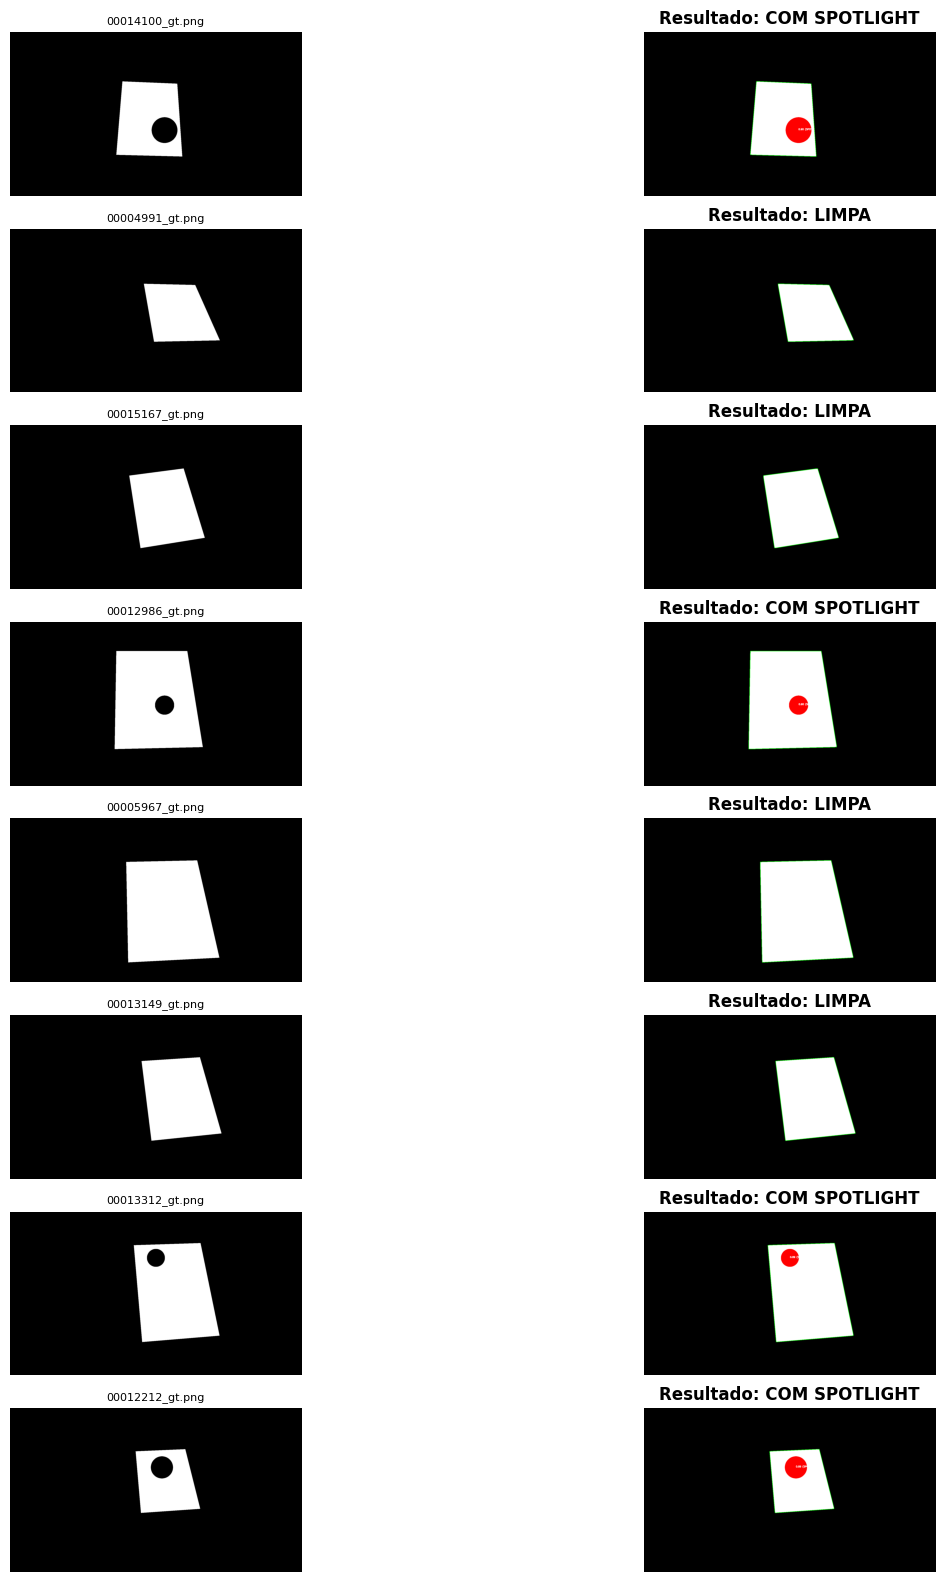

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# CONFIGURAÇÃO
RAW_DATASET_PATH = Path("/content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID Set Dataset")

def calculate_circularity(contour):
    """Calcula o quão próximo de um círculo é o contorno (0.0 a 1.0)"""
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0: return 0
    # Fórmula matemática da circularidade: 4 * pi * Area / (Perimetro^2)
    # Círculo perfeito = 1.0
    # Quadrado = 0.78
    # Linha fina = ~0.0
    circularity = 4 * np.pi * area / (perimeter * perimeter)
    return circularity

def debug_shape_logic(mask_path):
    # 1. Ler e binarizar
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None: return None, None, False
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 2. Limpeza de Ruído (Morphology)
    # Remove pontinhos brancos minúsculos que atrapalham o Hull
    kernel = np.ones((5,5), np.uint8)
    clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # 3. Convex Hull
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return binary_mask, binary_mask, False

    largest_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour)

    hull_mask = np.zeros_like(clean_mask)
    cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

    # 4. Diferença (Candidatos a Spotlight)
    candidates_mask = cv2.bitwise_xor(hull_mask, clean_mask)

    # 5. Analisar cada "buraco" individualmente
    spotlight_contours, _ = cv2.findContours(candidates_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    debug_img = cv2.cvtColor(clean_mask, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(debug_img, [hull], -1, (0, 255, 0), 2) # Hull em Verde

    has_real_spotlight = False

    for cnt in spotlight_contours:
        area = cv2.contourArea(cnt)

        # Filtro 1: Área Mínima (ignora ruído pequeno)
        if area < 300:
            continue

        # Filtro 2: Circularidade (ignora falhas alongadas do Hull)
        circ = calculate_circularity(cnt)

        # Desenhar no debug
        # Se circularidade > 0.3 (aceita meio-círculo ou círculo deformado)
        # E se não for ENORME (spotlight raramente é 30% da imagem)
        image_area = mask.shape[0] * mask.shape[1]

        is_spotlight = (circ > 0.3) and (area < image_area * 0.2)

        if is_spotlight:
            color = (255, 0, 0) # VERMELHO (Spotlight Confirmado)
            has_real_spotlight = True
            label = f"{circ:.2f} (SPOT)"
        else:
            color = (0, 0, 255) # AZUL (Falso Positivo - Ignorado)
            label = f"{circ:.2f} (FAKE)"

        cv2.drawContours(debug_img, [cnt], -1, color, -1) # Pinta preenchido

        # Põe texto da circularidade perto do objeto
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.putText(debug_img, label, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return binary_mask, debug_img, has_real_spotlight

def show_shape_preview():
    # Tenta pegar imagens variadas
    all_masks = list((RAW_DATASET_PATH / 'train_folder').glob("*_gt.png"))
    if not all_masks: return
    samples = random.sample(all_masks, min(8, len(all_masks)))

    plt.figure(figsize=(15, 20))
    for i, mask_path in enumerate(samples):
        original, processed, has_spot = debug_shape_logic(mask_path)
        if original is None: continue

        plt.subplot(8, 2, i*2 + 1)
        plt.imshow(original, cmap='gray')
        plt.title(mask_path.name, fontsize=8)
        plt.axis('off')

        plt.subplot(8, 2, i*2 + 2)
        plt.imshow(processed)
        plt.title(f"Resultado: {'COM SPOTLIGHT' if has_spot else 'LIMPA'}", fontweight='bold')
        plt.axis('off')

    plt.show()

show_shape_preview()

Com esssa técnica conseguimos classificar as imagens que tem ou não tem as mascaras de ponto de luz e preservar até as imagens que contém as máscaras de ponto de luz nas laterais, e depois criamos o dataset aplicando o algoritmo Convex Hull com a função customizada.

In [ ]:
# ==============================================================================
# ETAPA 1: ORGANIZAÇÃO DO DATASET (RODAR EM CPU)
# ==============================================================================
import os
import shutil
import cv2
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

# --- CONFIGURAÇÃO ---
# Onde estão os arquivos originais (bagunçados)
RAW_DATASET_PATH = Path("/content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID Set Dataset")

# Onde vamos salvar os arquivos organizados (PARA O DRIVE, PARA NÃO PERDER!)
# Dica: Zipar no final é melhor para transferir depois, mas vamos copiar pastas por enquanto
ORGANIZED_PATH = Path("/content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID_Organized_v3")

# ==============================================================================
# LÓGICA DE DETECÇÃO (IGUAL AO ANTERIOR)
# ==============================================================================
def has_valid_spotlight(mask_path):
    """
    Lógica FINAL: Convex Hull + Filtro de Circularidade.
    Diferencia falhas no papel (tiras) de spotlights reais (bolas).
    """
    # 1. Ler e binarizar
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None: return False
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 2. Limpeza (Morphology)
    kernel = np.ones((5,5), np.uint8)
    clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # 3. Convex Hull
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return False

    largest_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour)

    hull_mask = np.zeros_like(clean_mask)
    cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

    # 4. Diferença (Candidatos)
    candidates_mask = cv2.bitwise_xor(hull_mask, clean_mask)

    # 5. Analisar cada candidato individualmente
    spotlight_contours, _ = cv2.findContours(candidates_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_area = mask.shape[0] * mask.shape[1]

    for cnt in spotlight_contours:
        area = cv2.contourArea(cnt)

        # Filtro de Tamanho (nem pó, nem a imagem toda)
        if area < 300 or area > (image_area * 0.3):
            continue

        # Filtro de Circularidade
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0: continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)

        # SE passar no teste, retornamos True imediatamente (basta 1 spotlight para condenar a foto)
        if circularity > 0.3:
            return True

    # Se analisou todos os candidatos e nenhum era spotlight válido
    return False

# ==============================================================================
# EXECUÇÃO
# ==============================================================================
def run_organization():
    if not RAW_DATASET_PATH.exists():
        print("❌ Dataset original não encontrado!")
        return

    # Criar pastas no destino (No Drive)
    for split in ['train', 'val']:
        for label in ['clean', 'spotlight']:
            (ORGANIZED_PATH / split / label).mkdir(parents=True, exist_ok=True)

    print(f"🚀 Iniciando organização de ~16k imagens...")
    print(f"📂 Lendo de: {RAW_DATASET_PATH}")
    print(f"💾 Salvando em: {ORGANIZED_PATH}")
    print("☕ Pode ir tomar um café, isso vai levar uns 40-60 minutos...")

    source_folders = {
        'train': RAW_DATASET_PATH / 'train_folder',
        'val': RAW_DATASET_PATH / 'validation_folder'
    }

    counter = 0

    for split, folder_path in source_folders.items():
        masks = list(folder_path.glob("*_gt.png"))

        for mask_path in tqdm(masks, desc=f"Processando {split}"):
            # Achar imagem original
            img_name = mask_path.name.replace("_gt.png", "_in.png")
            img_path = mask_path.parent / img_name

            if not img_path.exists(): continue

            # Verificar se é spotlight ou clean
            if has_valid_spotlight(mask_path):
                dest_dir = ORGANIZED_PATH / split / 'spotlight'
            else:
                dest_dir = ORGANIZED_PATH / split / 'clean'

            # Copiar arquivo (Isto é o que demora no Drive)
            # Verifica se já existe para não copiar de novo se cair a conexão
            dest_file = dest_dir / img_name
            if not dest_file.exists():
                shutil.copy(img_path, dest_file)

            counter += 1

    print(f"\n✅ SUCESSO! {counter} imagens organizadas em {ORGANIZED_PATH}")

run_organization()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Iniciando organização de ~16k imagens...
📂 Lendo de: /content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID Set Dataset
💾 Salvando em: /content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID_Organized_v3
☕ Pode ir tomar um café, isso vai levar uns 40-60 minutos...


Processando train:   0%|          | 0/15650 [00:00<?, ?it/s]

Processando val:   0%|          | 0/5216 [00:00<?, ?it/s]


✅ SUCESSO! 20866 imagens organizadas em /content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID_Organized_v3


Aqui passamos por uma verificação do dataset para encontrar arquivos corrompidos assim evitando possíveis erros no treino do modelo

In [ ]:
import os
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from google.colab import drive

# 1. Montar o Drive
drive.mount('/content/drive')

# ==============================================================================
# CONFIGURAÇÃO - ONDE ESTÁ O DATASET NO DRIVE?
# ==============================================================================
# Ajuste aqui para a pasta que você criou (v3 ou v4)
DRIVE_PATH = Path("/content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID_Organized_v3")

print(f"🕵️‍♂️ Iniciando inspeção forense em: {DRIVE_PATH}")

if not DRIVE_PATH.exists():
    print("❌ Caminho não encontrado! Verifique o nome da pasta.")
else:
    # Listar todas as imagens
    print("📋 Listando arquivos (isso pode demorar um pouquinho no Drive)...")
    image_files = list(DRIVE_PATH.rglob("*.png")) + list(DRIVE_PATH.rglob("*.jpg"))

    print(f"🔍 Verificando integridade de {len(image_files)} imagens...")

    bad_files = []

    # Verificar uma por uma
    for img_path in tqdm(image_files):
        try:
            # Tenta abrir apenas o cabeçalho (rápido) e verificar
            with Image.open(img_path) as img:
                img.verify()
        except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
            print(f"❌ ARQUIVO CORROMPIDO ENCONTRADO: {img_path.name}")
            bad_files.append(img_path)

    # Deletar os arquivos ruins do Drive
    if bad_files:
        print(f"\n⚠️ Removendo {len(bad_files)} arquivos corrompidos do Drive...")
        for bad_file in bad_files:
            try:
                os.remove(bad_file)
                print(f"   🗑️ Deletado permanentemente: {bad_file.name}")
            except Exception as e:
                print(f"   Erro ao deletar {bad_file.name}: {e}")
        print("\n✨ Limpeza concluída! O Drive está seguro.")
    else:
        print("\n✅ Nenhuma imagem corrompida encontrada. O Dataset está 100%!")

Mounted at /content/drive
🕵️‍♂️ Iniciando inspeção forense em: /content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID_Organized_v3
📋 Listando arquivos (isso pode demorar um pouquinho no Drive)...
🔍 Verificando integridade de 20866 imagens...


  0%|          | 0/20866 [00:00<?, ?it/s]

❌ ARQUIVO CORROMPIDO ENCONTRADO: 00005796_in.png

⚠️ Removendo 1 arquivos corrompidos do Drive...
   🗑️ Deletado permanentemente: 00005796_in.png

✨ Limpeza concluída! O Drive está seguro.
